In [2]:
import glob
import numpy as np
import cv2
from skimage.feature import hog
import  matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images

In [3]:
def get_hog_features(image, orientations=9, pixels_per_cell=8, cells_per_block=2, viz=False):
    if viz:
        return hog(image[:,:,0], orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell), 
                        cells_per_block=(cells_per_block, cells_per_block), 
                        visualise=True, feature_vector=False)
    
    return hog(image[:,:,0], orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell), 
                        cells_per_block=(cells_per_block, cells_per_block), 
                        visualise=False, feature_vector=True)
        

In [4]:
def convert_color(img, cspace='LUV'):
    if cspace == 'RGB':
        return img
    if cspace == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif cspace == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif cspace == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif cspace == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return feature_image      

In [5]:
def color_histogram(img, bins=32, bins_range=(0,256)):
    channels = []
    h,w,c = img.shape
    for i in range(c):
        channel = np.histogram(img[:,:,i], bins=bins, range=bins_range)
        channels.append(channel[0])
    return np.concatenate(channels)

In [6]:
def bin_spatial(img, size=(32,32)):
    return cv2.resize(img, size).ravel()

In [7]:
def get_features(img):
    feature_image = convert_color(img)
    
    hog_features = get_hog_features(feature_image)
    spatial_features = bin_spatial(feature_image)
    color_features = color_histogram(feature_image)
    return np.concatenate((hog_features, spatial_features, color_features))

In [8]:
def load_image(img_path):
    img = cv2.imread(img_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [9]:
def extract_features(image_paths):
    features = []
    for image_path in image_paths:
        img = load_image(image_path)
        features.append(get_features(img))
    
    return features

In [10]:
cars = glob.glob('data/vehicles/*/*')
noncars = glob.glob('data/non-vehicles/*/*')

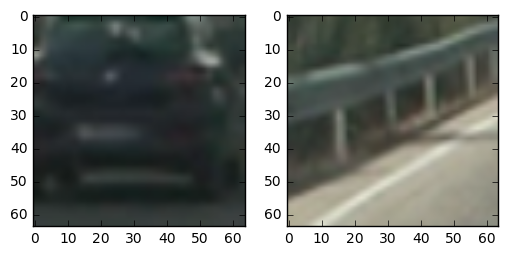

In [85]:
car = load_image(cars[0])
nocar = load_image(noncars[0])
f, ax = plt.subplots(1, 2)
ax[0].imshow(car)
ax[1].imshow(nocar)
plt.savefig('output_images/car_nocar.jpg')
plt.show()


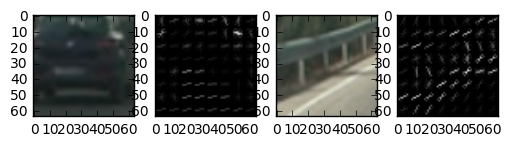

In [86]:
f, ax = plt.subplots(1, 4)
ax[0].imshow(car)
ax[1].imshow(get_hog_features(car, viz=True)[1], cmap='gray')
ax[2].imshow(nocar)
ax[3].imshow(get_hog_features(nocar, viz=True)[1], cmap='gray')
plt.savefig('output_images/hog_features.jpg')
plt.show()


In [21]:
car_features = extract_features(cars)
noncar_features = extract_features(noncars)
X = np.vstack((car_features, noncar_features)).astype(np.float64)
print(X.shape)

car_labels = np.ones(len(cars))
noncar_labels = np.zeros(len(noncars))
y = np.hstack((car_labels, noncar_labels))
print(y.shape)


(17760, 4932)
(17760,)


In [22]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [23]:
import time
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

acc = svc.score(X_test, y_test)
print('Accuracy', acc)

Accuracy 0.984234234234


In [24]:
def draw_boxes(img, bboxes, color=(0,0,255)):
    res = np.copy(img)
    for top, bottom in bboxes:
        cv2.rectangle(res, top, bottom, color=color, thickness=6)
    return res

In [25]:
def get_windows(img, y_start_stop, window_size=100, overlap=0.7):
    h,w,c = img.shape
    xspan = w
    yspan = y_start_stop[1] - y_start_stop[0]
    
    step = int(window_size * (1.0-overlap))
    x_windows = (xspan//step) 
    y_windows = (yspan//step) 
    
    windows = []
    for y in range(y_windows):
        for x in range(x_windows):
            top_x = x*step
            top_y = y_start_stop[0] + y*step
            bottom_x = top_x + window_size
            bottom_y = top_y + window_size
            windows.append(((top_x, top_y), (bottom_x, bottom_y)))
    
    return windows

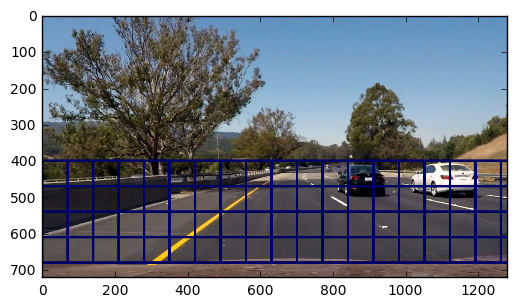

In [81]:
img = load_image('test_images/test6.jpg')

windows = get_windows(img, y_start_stop=(400,650), window_size=140, overlap=0.5)
res = draw_boxes(test_image, windows, color=(0,0,100))
plt.imshow(res)
plt.savefig('output_images/sliding_windows140.jpg')
plt.show()


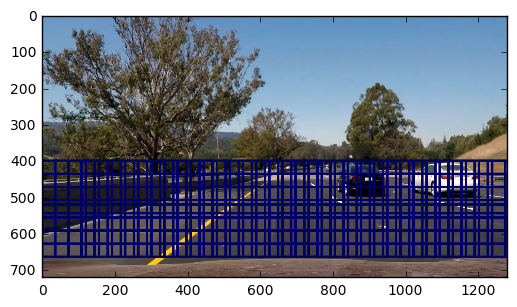

In [82]:
windows = get_windows(img, y_start_stop=(400,600), window_size=120, overlap=0.7)
res = draw_boxes(test_image, windows, color=(0,0,100))
plt.imshow(res)
plt.savefig('output_images/sliding_windows120.jpg')
plt.show()

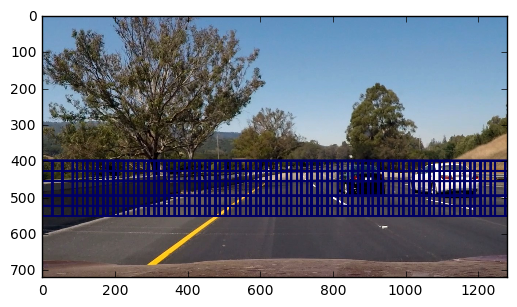

In [83]:
windows = get_windows(img, y_start_stop=(400,500), window_size=96, overlap=0.7)
res = draw_boxes(test_image, windows, color=(0,0,100))
plt.imshow(res)
plt.savefig('output_images/sliding_windows96.jpg')
plt.show()

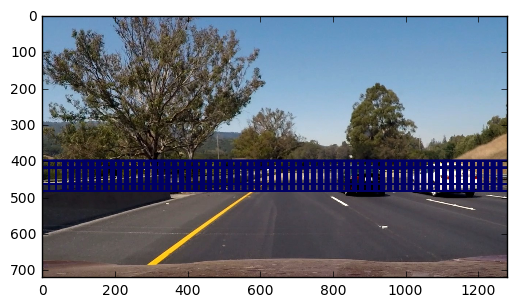

In [84]:
windows = get_windows(test_image, y_start_stop=(400,450), window_size=64, overlap=0.7)
res = draw_boxes(test_image, windows, color=(0,0,100))
plt.imshow(res)
plt.savefig('output_images/sliding_windows64.jpg')
plt.show()


In [60]:
windows = get_windows(test_image, y_start_stop=(400,450), window_size=96, overlap=0.7)

def search_windows(img, windows, clf, scaler):
    features = []
    for window in windows:
        x1, y1 = window[0]
        x2, y2 = window[1]
        test_img = img[y1:y2, x1:x2, :]
        test_img = cv2.resize(test_img, (64,64))
        features.append(get_features(test_img))
    
    features_tensor = np.array(features)
    features_tensor = scaler.transform(features_tensor)
    prediction = clf.predict(features_tensor)
    return [windows[i] for i in range(len(windows)) if prediction[i] == 1]

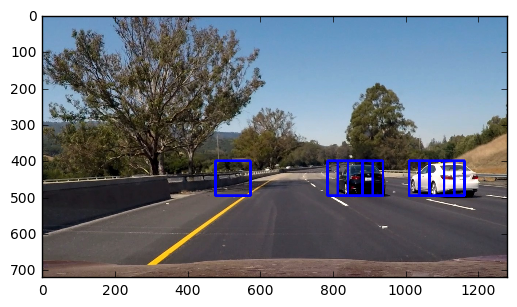

In [78]:
detected = search_windows(img, windows, svc, scaler)
res = draw_boxes(test_image, detected)
plt.imshow(res)

plt.savefig('output_images/sliding_window.jpg')
plt.show()

labeled boxes 2


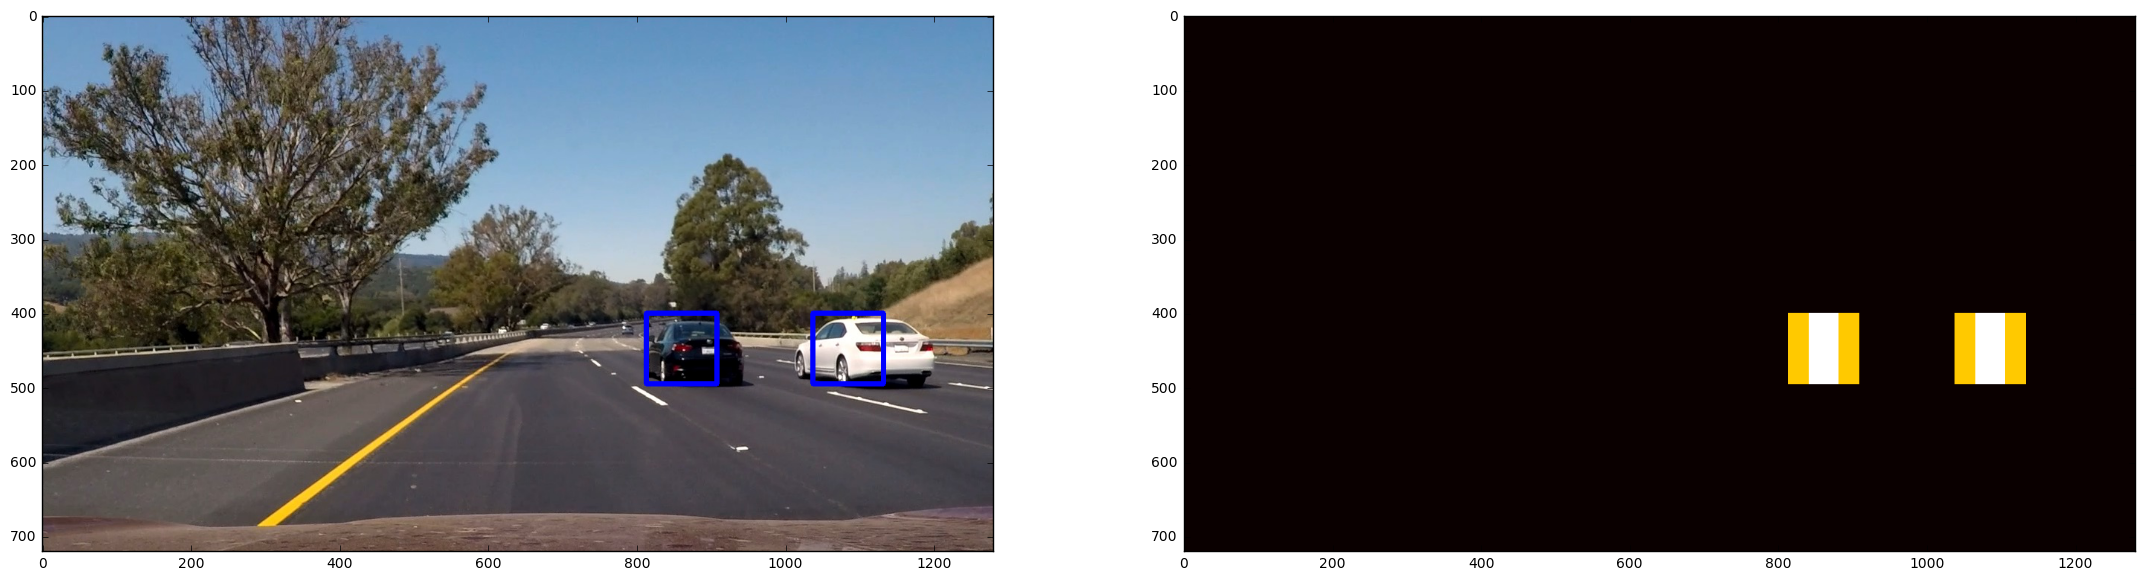

In [63]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bboxes):
    for box in bboxes:
        x1, y1 = box[0]
        x2, y2 = box[1]
        heatmap[y1:y2, x1:x2] += 1
    return heatmap

def apply_threashold(heatmap, tresh):
    heatmap[(heatmap<tresh)]=0

def get_labeled_boxes(labels):
    bboxes = []
    for car in range(labels[1]):
        nonzero = (labels[0] == car+1).nonzero()
        
        nonzero_x = np.array(nonzero[1])
        nonzero_y = np.array(nonzero[0])
        
        top_x, top_y = np.min(nonzero_x), np.min(nonzero_y)
        bottom_x, bottom_y = np.max(nonzero_x), np.max(nonzero_y)
        
        bboxes.append(((top_x,top_y), (bottom_x, bottom_y)))
    return bboxes
                      
res = draw_boxes(test_image, detected)
heatmap = np.zeros_like(test_image[:,:,0]).astype(np.float32)
heatmap = add_heat(heatmap, detected)
apply_threashold(heatmap, 2)
labels = label(heatmap)

labeled_boxes = get_labeled_boxes(labels)
print('labeled boxes', len(labeled_boxes))
res_final = draw_boxes(test_image, labeled_boxes)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(27,9))
ax1.imshow(res_final)
ax2.imshow(heatmap, cmap='hot')
plt.show()

In [67]:
def process_image(img, heatmap=heatmap, clf=svc, scaler=scaler, sizes=[140, 120, 96, 64]):
    #heatmap -= 5
    heatmap = np.zeros_like(test_image[:,:,0]).astype(np.float32)
    heatmap = np.clip(heatmap, 0, 255)
    h,w,c = img.shape
    height = 250
    for i, size in enumerate(sizes):
        y_start_stop = (400, 400+height//(i+1))
        
        windows = get_windows(img, y_start_stop , size, overlap=0.5)
        if i == 6:
            img = draw_boxes(img,[((0,y_start_stop[0]), (w, y_start_stop[1]))], color=(0,0,255))
            img = draw_boxes(img, windows, color=(0,255,0))
        detected = search_windows(img, windows, clf, scaler)
        
        #img = draw_boxes(img, detected)
        heatmap = add_heat(heatmap, detected)

    apply_threashold(heatmap, 2)
    labels = label(heatmap)
    bboxes = get_labeled_boxes(labels)

    return draw_boxes(img, bboxes), heatmap, labels


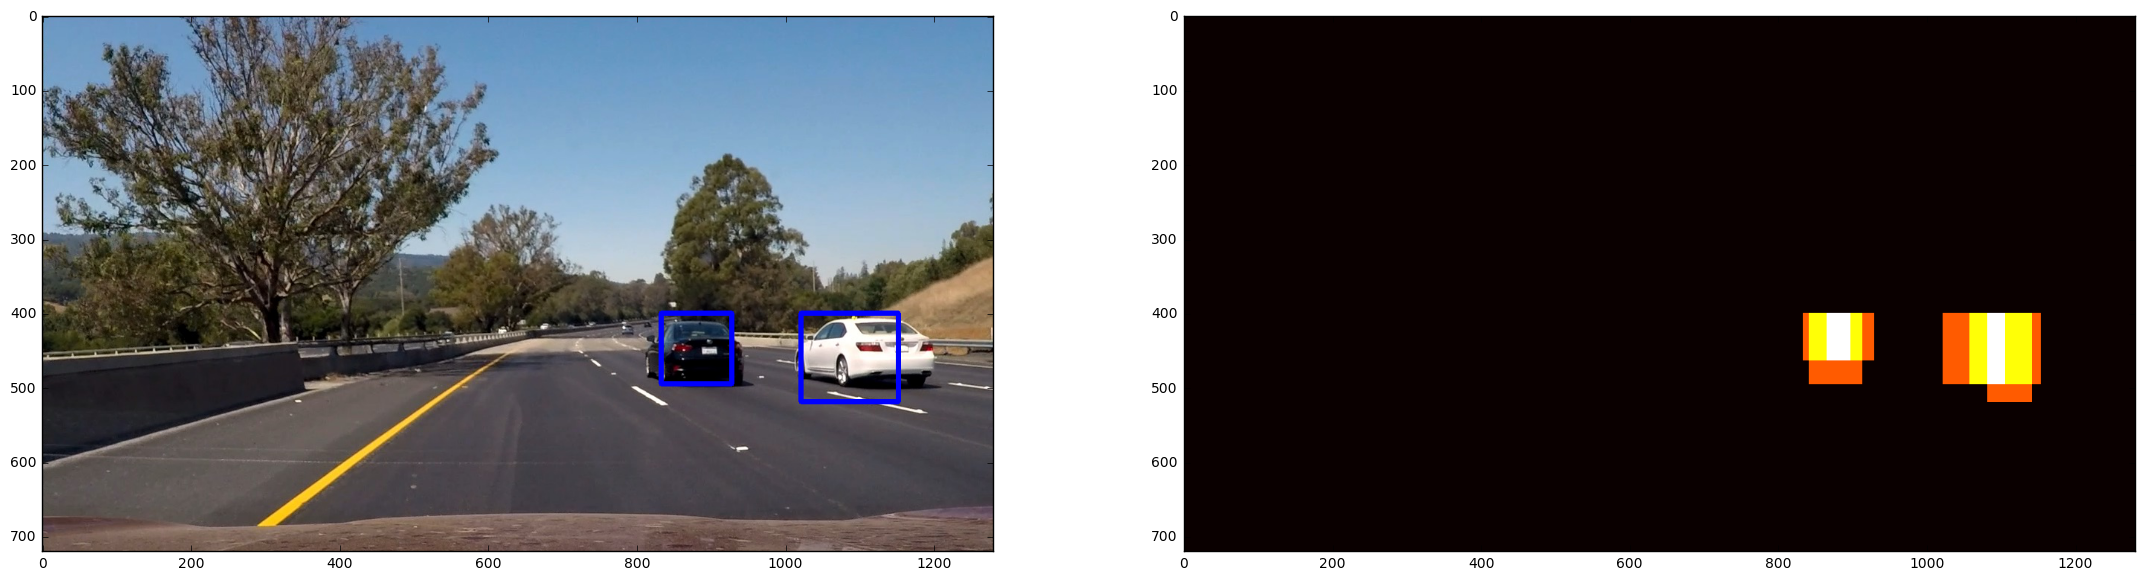

In [74]:
heatmap = np.zeros_like(img[:,:,0]).astype(np.float32)

res, heatmap, labels = process_image(test_image)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(27,9))
ax1.imshow(res)
ax2.imshow(heatmap, cmap='hot')
plt.show()
f.savefig('output_images/bboxes_and_heat.png')

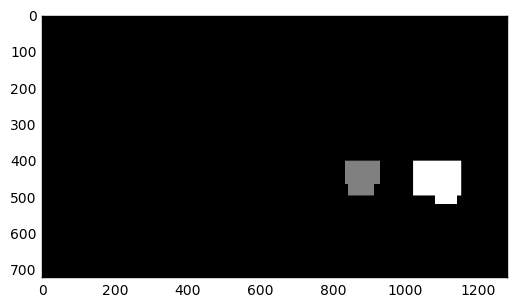

In [79]:
plt.imshow(labels[0], cmap='gray')
plt.savefig('output_images/labels_map.png')
plt.show()

In [80]:
from moviepy.editor import VideoFileClip
from vehicle_detector import VehicleDetector
detector = VehicleDetector(svc, scaler, 0.7)
white_output = './output_images/test_video_output.mp4'
clip1 = VideoFileClip("./test_video.mp4")
white_clip = clip1.fl_image(detector.process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./output_images/test_video_output.mp4
[MoviePy] Writing video ./output_images/test_video_output.mp4


 97%|█████████▋| 38/39 [00:38<00:01,  1.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/test_video_output.mp4 

CPU times: user 47.7 s, sys: 1min 7s, total: 1min 55s
Wall time: 39.6 s


In [40]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))